In [2]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.model_selection import train_test_split
import csv

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from experiment_helpers.metrics import * 
from src.solvers import *
from src.syntetic import *




In [20]:

def plot_error_results(ax, results, method):
    """Plot the accuracy comparison for a specific method on a given axis."""
    ax.set_title(f'Accuracy Comparison - {method}')
    ax.set_ylabel(method)
    ax.set_xlabel('Test Size')
    
  
    independent = [experiment['test_size'] for experiment in results]
    graph_accuracy = [experiment['graph_accuracy'] for experiment in results]
    hyper_graph_accuracy = [experiment['hyper_graph_accuracy'] for experiment in results]

    ax.plot(independent, graph_accuracy, label='Standard Graph Accuracy', marker='o')
    ax.plot(independent, hyper_graph_accuracy, label='Hyper-graph Accuracy', marker='s')

    ax.legend()
    # ax.grid(True)

def plot_all_error_results(results_dict):
    """Plot the error comparison for all methods in a single row."""
    methods = list(results_dict.keys())
    num_methods = len(methods)
    
    fig, axs = plt.subplots(1, num_methods, figsize=(6 * num_methods, 6))

    for i, method in enumerate(methods):
        plot_error_results(axs[i], results_dict[method], method)
    
    plt.tight_layout()
    plt.show()

def measure_experiment(predicted_scores : dict[str:int], ground_truth_scores: dict[str:int], loss_measurement: str) -> float:

    if loss_measurement == 'rms':
        return calculate_rms(predicted_scores, ground_truth_scores)
    elif loss_measurement == 'rho':
        return calculate_rho(predicted_scores, ground_truth_scores)
    elif loss_measurement == 'tau':
        return calculate_tau(predicted_scores, ground_truth_scores)
    else:
        return 0 

def test_training_size(N,M,K1,K2, loss_measurement ='rms', repetitions = 5):

    all_results = []

    pi_values, data = generate_model_instance(N, M, K1, K2)


    for train_size in np.arange(0, 1.1, 0.1):

        hyper_graph_accuracy = []
        graph_accuracy = []

        for _ in range(repetitions):

            X_train, X_test, y_train, y_test = train_test_split(data, pi_values, test_size=1-train_size)
           
            # Create hypergraph
            bond_matrix = create_hypergraph_from_data(X_train)

            # Standard graph
            bin_data = binarize_data(X_train)
            bin_bond_matrix = create_hypergraph_from_data(bin_data)
            
            # predict ranks based on subset of games
            predicted_hyper_graph_scores , _ = synch_solve_equations(bond_matrix, 500, X_test, 'newman', sens=1e-6)
            predicted_graph_scores, _ = synch_solve_equations(bin_bond_matrix, 500, X_test, 'newman', sens=1e-6)

            # Measure accuracy for hypergraph and standard graph
            hyper_graph_accuracy.append( measure_experiment(predicted_hyper_graph_scores, pi_values, loss_measurement) )
            graph_accuracy.append( measure_experiment(predicted_graph_scores, pi_values, loss_measurement) )

        all_results.append({
            'loss_measurement': loss_measurement,
            'test_size': train_size,
            'graph_accuracy': np.mean(graph_accuracy),
            'hyper_graph_accuracy': np.mean(hyper_graph_accuracy)
        })

    print(all_results)
    return all_results


def run_all_metrics(M, N, K1, K2): 

    rms = test_training_size(N,M,K1,K2, loss_measurement ='rms')
    rho = test_training_size(N,M,K1,K2, loss_measurement = 'rho')
    tau = test_training_size(N,M,K1,K2, loss_measurement = 'tau')

    results_dict = {
        'rms': rms,
        'rho': rho,
        'tau': tau
    }

    plot_all_error_results(results_dict)
    


def save_results_to_csv(filename, results, experiment_label):
    fieldnames = ['experiment_label', 'test_size', 'graph_accuracy', 'hyper_graph_accuracy', 'loss_measurement']
    file_exists = os.path.isfile(filename)
    
    with open(filename, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        for result in results:
            result['experiment_label'] = experiment_label
            writer.writerow(result)
   

/home/jackyeung99/senior_thesis/higher_order_ranking/experiments/experiment_helpers/metrics.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_val = spearmanr(predicted_scores, true_scores)


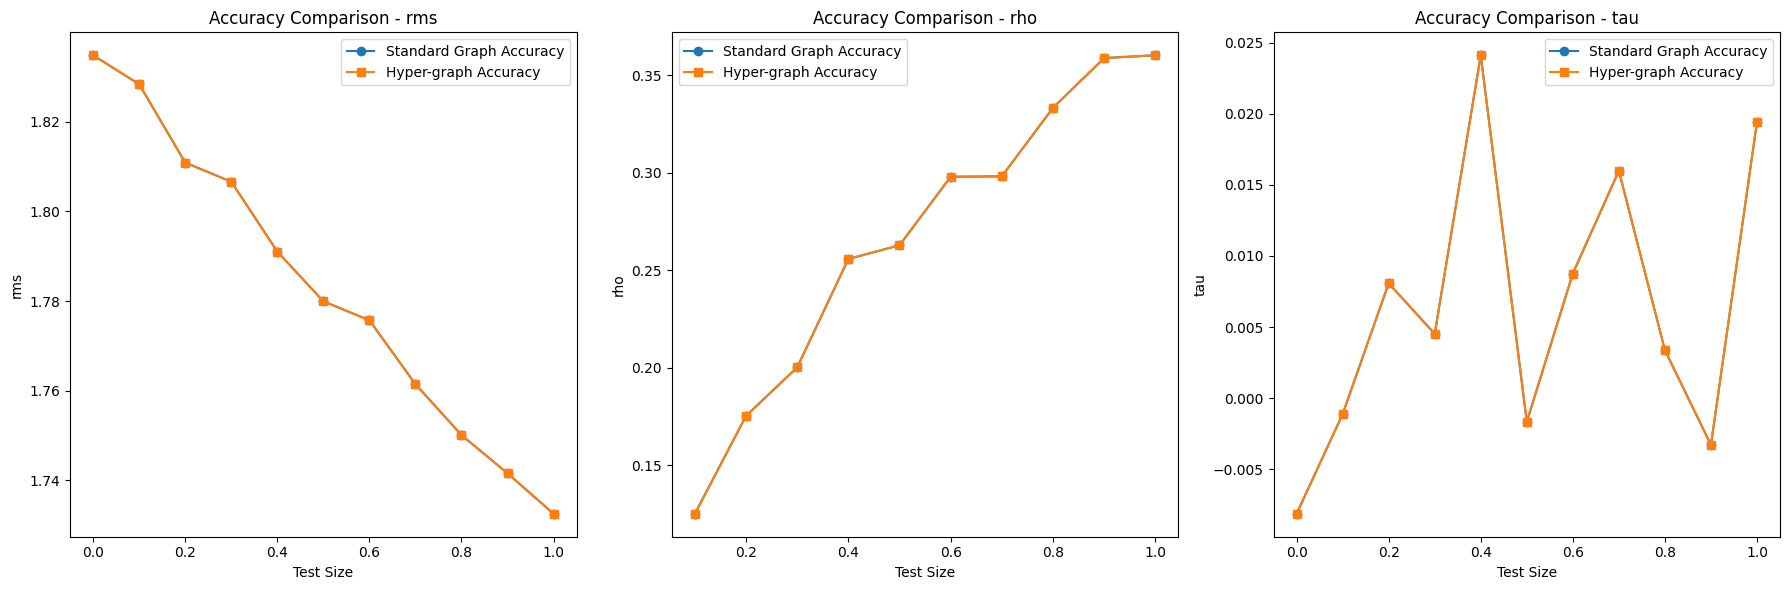

In [37]:
# Check dyadic hyperedges and standard graph produce the same results
run_all_metrics(250,750,2,2)


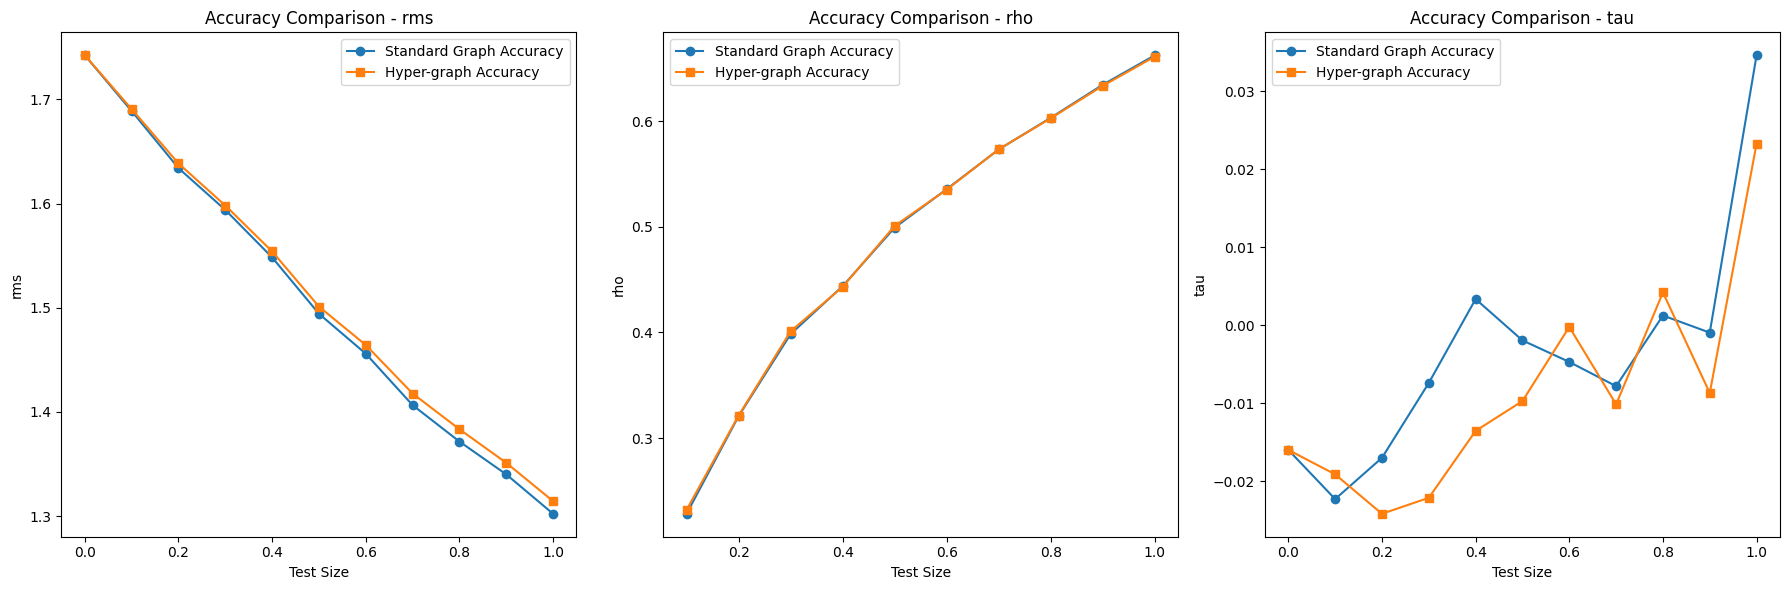

In [78]:
# Syntethic golf tournament example
run_all_metrics(1000,1500,2,4)


/home/jackyeung99/senior_thesis/higher_order_ranking/experiments/experiment_helpers/metrics.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_val = spearmanr(predicted_scores, true_scores)


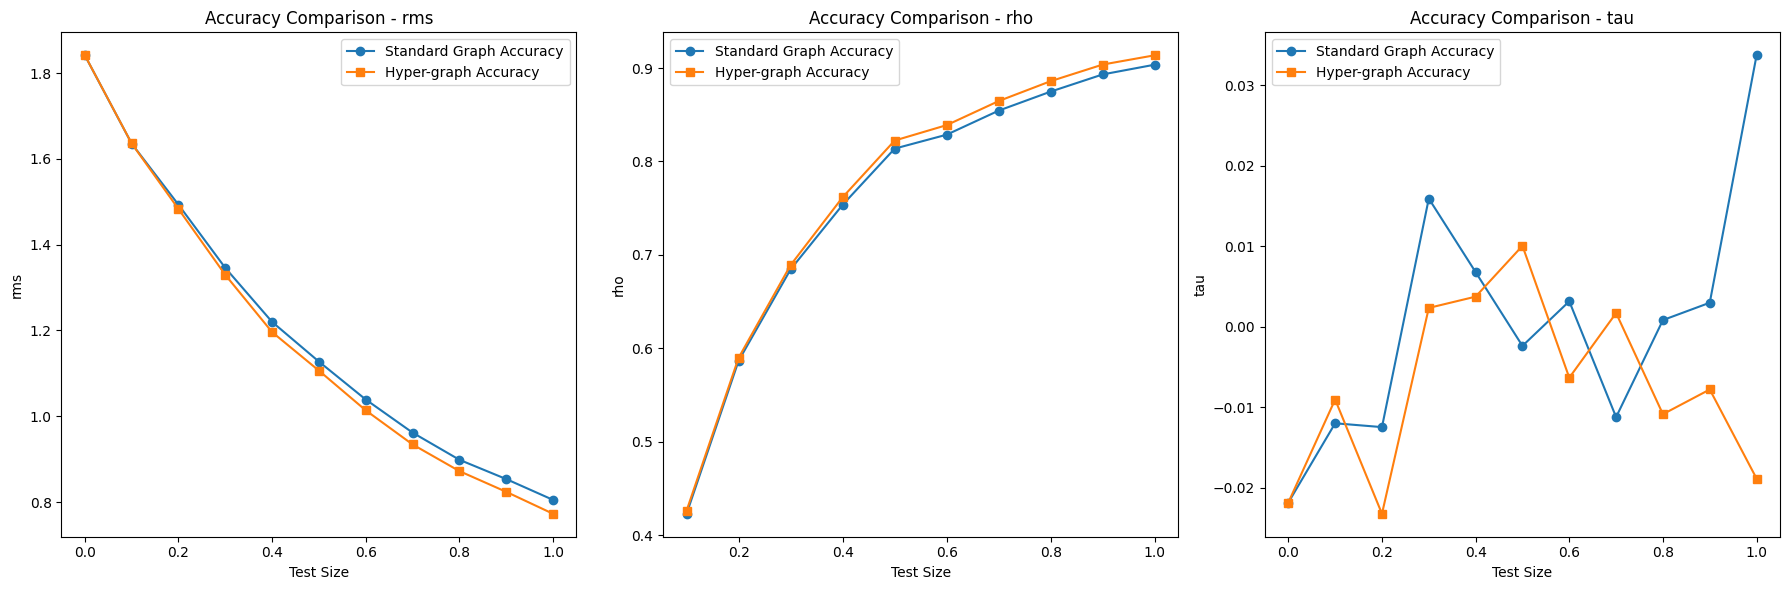

In [77]:
# sample poker tournament
# stage one 
run_all_metrics(600,1200,9,10)

In [34]:




training_regime = [
     {'label': '1:.5', 'M': 250, 'N': 125, 'K1': 5, 'K2': 10, 'loss_measurement': 'rms'},
     {'label': '1:1', 'M': 250, 'N': 250, 'K1': 5, 'K2': 10, 'loss_measurement': 'rms'},
     {'label': '1:5','M': 250, 'N': 1250, 'K1': 5, 'K2': 10, 'loss_measurement': 'rms'},
     {'label': '1:10','M': 250, 'N': 2500, 'K1': 5, 'K2': 10, 'loss_measurement': 'rms'},

     {'label': '1:.5', 'M': 250, 'N': 125, 'K1': 5, 'K2': 10, 'loss_measurement': 'tau'},
     {'label': '1:1', 'M': 250, 'N': 250, 'K1': 5, 'K2': 10, 'loss_measurement': 'tau'},
     {'label': '1:5','M': 250, 'N': 1250, 'K1': 5, 'K2': 10, 'loss_measurement': 'tau'},
     {'label': '1:10','M': 250, 'N': 2500, 'K1': 5, 'K2': 10, 'loss_measurement': 'tau'},
     
     {'label': '1:.5', 'M': 250, 'N': 125, 'K1': 5, 'K2': 10, 'loss_measurement': 'rho'},
     {'label': '1:1', 'M': 250, 'N': 250, 'K1': 5, 'K2': 10, 'loss_measurement': 'rho'},
     {'label': '1:5','M': 250, 'N': 1250, 'K1': 5, 'K2': 10, 'loss_measurement': 'rho'},
     {'label': '1:10','M': 250, 'N': 2500, 'K1': 5, 'K2': 10, 'loss_measurement': 'rho'}
]

filename = 'experiment_results.csv'

for experiment in training_regime: 
    results = test_training_size(experiment['M'], experiment['N'], experiment['K1'], experiment['K2'], experiment['loss_measurement'])
    save_results_to_csv(filename, results, experiment['label'])

KeyboardInterrupt: 

Parameter Search

In [59]:

def evaluate_model(N, M, K1, K2, repetitions=5):
    results = test_training_size(N, M, K1, K2, 'rms', repetitions)
    test_sizes = np.arange(0, 1.1, 0.1)
    graph_accuracies = np.array([res['graph_accuracy'] for res in results])
    hyper_graph_accuracies = np.array([res['hyper_graph_accuracy'] for res in results])
    return test_sizes, graph_accuracies, hyper_graph_accuracies


def compute_area_between_curves(x, y1, y2):
    area = np.trapz((y1 - y2), x)
    return area

def compute_gradient(N, M, K1, K2, epsilon=1):
    base_x, base_graph_acc, base_hyper_graph_acc = evaluate_model(N, M, K1, K2)
    base_area = compute_area_between_curves(base_x, base_graph_acc, base_hyper_graph_acc)
    
    gradients = {}
    for param in ['N', 'M']:

        if param == 'N':
            _, delta_graph, delta_hyper = evaluate_model(N + 500, M, K1, K2)
        elif param == 'M':
            _, delta_graph, delta_hyper = evaluate_model(N, M + 500, K1, K2)
        
        delta_area = compute_area_between_curves(base_x, delta_graph, delta_hyper)
        gradients[param] = (delta_area - base_area) / epsilon
    
    return gradients

def gradient_descent(N, M, K1, K2, learning_rate=1, num_iterations=1000, epsilon=1e-4):
    for i in range(num_iterations):
        # compute gradient 
        gradients = compute_gradient(N, M, K1, K2, epsilon)
        
        # change paramters to increase gap 
        N += int(learning_rate * gradients['N'])
        M += int(learning_rate * gradients['M'])

        # calculate new area
        area = compute_area_between_curves(*evaluate_model(N, M, K1, K2))
        
        if i % 100 == 0:
            print(f"Iteration {i}, Area: {area}, Parameters: N={N}, M={M}, K1={K1}, K2={K2}")
    
    return N, M, K1, K2

# N, M, K1, K2 = 150, 500, 2, 5
# gradients = compute_gradient(N, M, K1, K2)
# print(gradients)
# N_opt, M_opt, K1_opt, K2_opt = gradient_descent(N, M, K1, K2)
# print(f"Optimized Parameters: N={N_opt}, M={M_opt}, K1={K1_opt}, K2={K2_opt}")


In [66]:
def compute_areas_for_ratios(N, M_values, K1, K2, repetitions):
    ratios = []
    areas = []
    stds = []

    for M in M_values:
        area = []
        ratio = N / M
        ratios.append(ratio)
        for _ in range(repetitions):    
            _ , graph_acc, hyper_graph_acc = evaluate_model(N, M, K1, K2)
            area.append( compute_area_between_curves(np.arange(0, 1.1, 0.1), graph_acc, hyper_graph_acc))
            
        areas.append(np.mean(area))
        stds.append(np.std(area))

    return ratios, areas, stds


M_values = range(100, 2000, 50)

# Compute areas for different ratios of N and M
ratios, areas, stds = compute_areas_for_ratios(1000, M_values, K1=2, K2=4, repetitions=10)

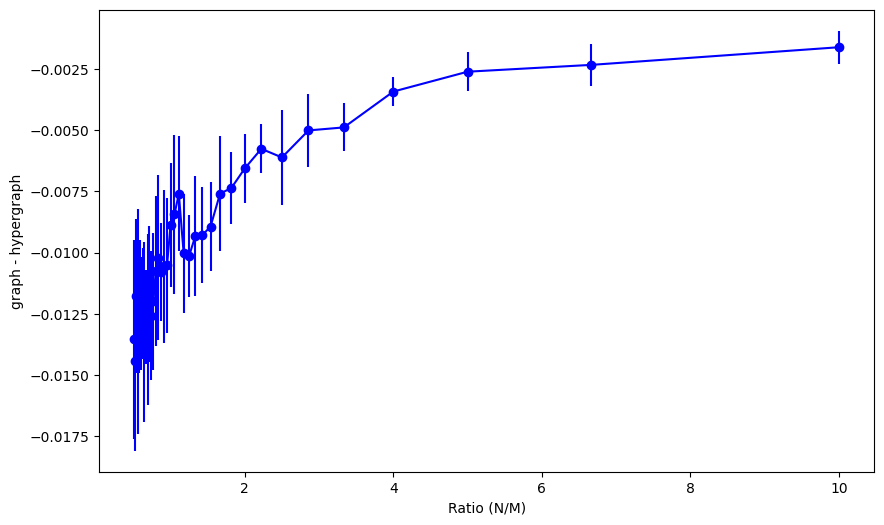

In [76]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.errorbar(ratios, areas, yerr=stds, c='blue', marker='o')
plt.xlabel('Ratio (N/M)')
plt.ylabel('graph - hypergraph')
# plt.xscale('log')
plt.show()

In [ ]:
T = 1
N = 10000
K1 = 2
K2 = 10


x , y, z  = [], [], []

M_vec = np.logspace(0, 18, num=9, endpoint= False, base=2.0)


for M in M_vec:
    
    